## Import requirements

In [1]:
import yaml, time, json, traceback
from collections import defaultdict
from typing import Dict, List
from pprint import PrettyPrinter
from tabulate import tabulate
import networkx as nx
from itertools import count
from fabrictestbed_extensions.fablib.fablib import fablib
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager

#### Define a better printer for debugging process

In [2]:
def pretty_print_defaultdict(d):
    # Create PrettyPrinter instance with custom formatting
    pp = PrettyPrinter(indent=4, width=80, sort_dicts=True)
    
    # Convert defaultdict to dict before printing
    pp.pprint(dict(d))

## Get values from YAML file

In [3]:
with open('./config4.yaml', 'r') as config_file:
    base_config = yaml.safe_load(config_file)
    
client_node_names: List[str] = base_config['topology']['client_nodes']
client_connections: Dict[str, List[str]] = base_config['topology']['client_connections']
general_node_names: List[str] = base_config['topology']['nodes']
general_connections: Dict[str, List[str]] = base_config['topology']['connections']

print(f'Client node names: {client_node_names}')
print(f'\nClient connections: {json.dumps(client_connections, indent=2)}')
print(f'\nGeneral node names: {general_node_names}')
print(f'\nGeneral connections: {json.dumps(general_connections, indent=2)}')

Client node names: ['node01']

Client connections: {
  "node01": [
    "node02"
  ]
}

General node names: ['node02', 'node03', 'node04']

General connections: {
  "node02": [
    "node03",
    "node04"
  ],
  "node03": [
    "node02"
  ],
  "node04": [
    "node02"
  ]
}


## Define global variables

In [4]:
manager = fablib_manager()

time_stamp = int(time.time())
experiment_slice = fablib.new_slice(name=f"hydra_auto_{time_stamp}")

# Basic node configs
experiment_cores = 4
experiment_ram = 8
experiment_disk = 20
experiment_image = "default_ubuntu_20"

# In case of fail, pick manually
def filter_sites(site):    
    try:
        if (site["state"] == "Active" and 
            site["hosts"] > 0 and 
            site["cores_available"] >= experiment_cores * 2 and 
            site["ram_available"] >= experiment_ram * 2 and 
            site["disk_available"] >= experiment_disk * 2
        ):
            return True
        return False
    except Exception as error:
        print(f"Filter error for site {site}: {error}")
        return False

# Change amount of site based on the topology size
experiment_sites = manager.get_random_sites(
    count=4,
    avoid=['NEWY', 'UCSD', 'EDUKY', 'TOKY'],
    filter_function=filter_sites,
    update=True,
    unique=True 
)

print(f'Available sites: {experiment_sites}')

Available sites: ['DALL', 'AMST', 'WASH', 'CERN']


## Add nodes and interfaces

In [5]:
site_selector = count()

nodes = defaultdict(dict)
nodes_interfaces = defaultdict(list)
client_nodes = defaultdict(dict)
client_interfaces = defaultdict(list)
networks = defaultdict(list)

# Helper function to count total connections for a node
def count_total_connections(node_name):
    # For client nodes, just count their outgoing connections
    if node_name in client_node_names:
        return len(client_connections.get(node_name, []))
    
    # For general nodes, count unique connections
    connections = set()
    
    # Add outgoing connections
    for target in general_connections.get(node_name, []):
        connections.add(tuple(sorted([node_name, target])))
    
    # Add incoming connections
    for source, targets in general_connections.items():
        if node_name in targets:
            connections.add(tuple(sorted([source, node_name])))
    
    # Add connections from clients
    for client, targets in client_connections.items():
        if node_name in targets:
            connections.add(tuple(sorted([client, node_name])))
            
    return len(connections)

try:
    # Add each client node to the slice
    for node_name in client_node_names:
        print(f'> Processing client {node_name}')
        current_node = experiment_slice.add_node(
            name=node_name,
            site=experiment_sites[next(site_selector) % len(experiment_sites)],
            cores=experiment_cores,
            ram=experiment_ram,
            disk=experiment_disk,
            image=experiment_image
        ) 
        
        # Calculate total needed interfaces for this client
        total_interfaces = count_total_connections(node_name)
        print(f'> {node_name} needs {total_interfaces} interfaces')
        
        # Add all needed interfaces to the node
        for i in range(total_interfaces):
            print(f'> \tAdding interface {i+1} to client {node_name}')
            new_connection = current_node.add_component(
                model='NIC_Basic', 
                name=f'nic-{node_name[-1]}-{i+1}'
            ).get_interfaces()[0]
            
            client_interfaces[node_name].append(new_connection)
        
        client_nodes[node_name] = current_node
        
    # Add each general node to the slice
    for node_name in general_node_names:
        print(f'> Processing {node_name}')
        
        current_node = experiment_slice.add_node(
            name=node_name,
            site=experiment_sites[next(site_selector) % len(experiment_sites)],
            cores=experiment_cores,
            ram=experiment_ram,
            disk=experiment_disk,
            image=experiment_image
        )
        
        # Calculate total needed interfaces for this node
        total_interfaces = count_total_connections(node_name)
        print(f'> {node_name} needs {total_interfaces} interfaces')
        
        # Add all needed interfaces to the node
        for i in range(total_interfaces):
            print(f'> \tAdding interface {i+1} to {node_name}')
            new_connection = current_node.add_component(
                model='NIC_Basic',
                name=f'nic-{node_name[-1]}-{i+1}'
            ).get_interfaces()[0]
            
            nodes_interfaces[node_name].append(new_connection)
            
        nodes[node_name] = current_node

    # Debug output
    print("\nInterface counts per node:")
    for node_name in client_nodes:
        print(f"{node_name}: {len(client_interfaces[node_name])} interfaces")
    for node_name in nodes:
        print(f"{node_name}: {len(nodes_interfaces[node_name])} interfaces")
    
    print("\nConnection counts per node:")
    for node_name in {**client_nodes, **nodes}:
        print(f"{node_name}: {count_total_connections(node_name)} connections")
    
except Exception as e:
    print(f"> Node configuration failed: \n{e}")
    traceback.print_exc(e)

> Processing client node01
> node01 needs 1 interfaces
> 	Adding interface 1 to client node01
> Processing node02
> node02 needs 3 interfaces
> 	Adding interface 1 to node02
> 	Adding interface 2 to node02
> 	Adding interface 3 to node02
> Processing node03
> node03 needs 1 interfaces
> 	Adding interface 1 to node03
> Processing node04
> node04 needs 1 interfaces
> 	Adding interface 1 to node04

Interface counts per node:
node01: 1 interfaces
node02: 3 interfaces
node03: 1 interfaces
node04: 1 interfaces

Connection counts per node:
node01: 1 connections
node02: 3 connections
node03: 1 connections
node04: 1 connections


## Add Networks

In [6]:
# Create copies of interface tables
client_interfaces_copy = {k: v[:] for k, v in client_interfaces.items()}
nodes_interfaces_copy = {k: v[:] for k, v in nodes_interfaces.items()}

# Helper function to check if nodes are already connected
def are_nodes_connected(node1, node2, networks):
    return any(
        f'net-{n1}-{n2}' in networks.get(node1, [])
        for n1 in [node1[-1], node2[-1]]
        for n2 in [node1[-1], node2[-1]]
    )

# Helper function to create network connection
def create_network_connection(source_node, target_node, source_interface, target_interface, networks):
    fixed_source_node_name = source_node[-2:] if int(source_node[-2:]) <= 50 else source_node[-1]
    fixed_target_node_name = target_node[-2:] if int(target_node[-2:]) <= 50 else target_node[-1]
    network_name = f'net-{fixed_source_node_name}-{fixed_target_node_name}'
    
    # Create L2 network
    experiment_slice.add_l2network(
        name=network_name,
        interfaces=[source_interface, target_interface]
    )
    
    # Record network connection
    networks[source_node].append(network_name)
    networks[target_node].append(network_name)

# Node_pair, src_interface, gateway_interface
interface_table: List[Dict[str, list[str]]] = []

# Process all connections from general_connections
processed_pairs = set()

try:
    # --- Add networks for clients
    for node_name in client_node_names:
        for connection in client_connections[node_name]:
            
            node_pair = tuple(sorted([node_name, connection]))
            # Check if these nodes are not already connected
            if not are_nodes_connected(node_name, connection, networks):
                
                # Check if interfaces are available for both nodes
                if (node_name in client_interfaces_copy and client_interfaces_copy[node_name] and
                    connection in nodes_interfaces_copy and nodes_interfaces_copy[connection]):
                    
                    # Get interfaces for the connection
                    source_interface = client_interfaces_copy[node_name][0]
                    target_interface = nodes_interfaces_copy[connection][0]
                    
                    create_network_connection(
                        node_name, connection,
                        source_interface, target_interface,
                        networks
                    )
                    
                    interface_table.append({
                        'Node pair': node_pair,
                        'Node A': source_interface.get_name(),
                        'Node B': target_interface.get_name(),
                    })
                    
                    # Remove used interfaces from copies
                    client_interfaces_copy[node_name].remove(source_interface)
                    nodes_interfaces_copy[connection].remove(target_interface)

    # --- Add networks for general nodes
    
    for source_node, target_nodes in general_connections.items():
        for target_node in target_nodes:
            # Create a sorted pair to avoid duplicates
            node_pair = tuple(sorted([source_node, target_node]))
            
            # Skip if this pair has been processed
            if node_pair in processed_pairs:
                continue
                
            # Check if these nodes are not already connected
            if not are_nodes_connected(source_node, target_node, networks):
                
                # Check if interfaces are available for both nodes
                if (source_node in nodes_interfaces_copy and nodes_interfaces_copy[source_node] and
                    target_node in nodes_interfaces_copy and nodes_interfaces_copy[target_node]):
                    
                    # Get interfaces for the connection
                    source_interface = nodes_interfaces_copy[source_node][0]
                    target_interface = nodes_interfaces_copy[target_node][0]
                    
                    interface_table.append({
                        'Node pair': node_pair,
                        'Node A': source_interface.get_name(),
                        'Node B': target_interface.get_name(),
                    })
                    
                    create_network_connection(
                        source_node, target_node, 
                        source_interface, target_interface, 
                        networks
                    )
                    
                    # Remove used interfaces from copies
                    nodes_interfaces_copy[source_node].remove(source_interface)
                    nodes_interfaces_copy[target_node].remove(target_interface)
            
            # Mark this pair as processed
            processed_pairs.add(node_pair)

except Exception as e:
    traceback.print_exc(e)

# Print debug information
print("Final networks:", dict(networks))
print("Remaining interfaces for nodes:", dict(nodes_interfaces_copy))
print("Remaining interfaces for clients:", dict(client_interfaces_copy))

Final networks: {'node01': ['net-01-02'], 'node02': ['net-01-02', 'net-02-03', 'net-02-04'], 'node03': ['net-02-03'], 'node04': ['net-02-04']}
Remaining interfaces for nodes: {'node02': [], 'node03': [], 'node04': []}
Remaining interfaces for clients: {'node01': []}


## Print information about nodes and connections

In [7]:
print(f'Nodes above. {pretty_print_defaultdict(nodes)}\n')
print(f'Nodes interfaces above. {pretty_print_defaultdict(nodes_interfaces)}\n')
print(f'Client nodes above. {pretty_print_defaultdict(client_nodes)}\n')
print(f'Client nodes interfaces above. {pretty_print_defaultdict(client_interfaces)}\n')
print(f'Networks above. {pretty_print_defaultdict(networks)}\n')

{   'node02': <fabrictestbed_extensions.fablib.node.Node object at 0x7f55287dc910>,
    'node03': <fabrictestbed_extensions.fablib.node.Node object at 0x7f55300c0750>,
    'node04': <fabrictestbed_extensions.fablib.node.Node object at 0x7f54e44a2390>}
Nodes above. None

{   'node02': [   <fabrictestbed_extensions.fablib.interface.Interface object at 0x7f55300bd410>,
    'node03': [   <fabrictestbed_extensions.fablib.interface.Interface object at 0x7f55312f03d0>],
    'node04': [   <fabrictestbed_extensions.fablib.interface.Interface object at 0x7f5504758a50>]}
Nodes interfaces above. None

{'node01': <fabrictestbed_extensions.fablib.node.Node object at 0x7f5531349890>}
Client nodes above. None

{   'node01': [   <fabrictestbed_extensions.fablib.interface.Interface object at 0x7f5504685e90>]}
Client nodes interfaces above. None

{   'node01': ['net-01-02'],
    'node02': ['net-01-02', 'net-02-03', 'net-02-04'],
    'node03': ['net-02-03'],
    'node04': ['net-02-04']}
Networks above. No

## Submit slice (Wait until Stable)

In [8]:
# Create a checkpoint and only execute the rest of the code if the slice is stable
try:
    experiment_slice.submit()
except Exception as e:
    print(f"Slice submission error: {e}")


Retry: 11, Time: 315 sec


ID,3be4dcc7-2f2a-4142-9ac3-e2e011f2f09b
Name,hydra_auto_1734358004
Lease Expiration (UTC),2024-12-17 14:07:23 +0000
Lease Start (UTC),2024-12-16 14:07:23 +0000
Project ID,b3cffedd-ddb4-43ee-b57d-459b768e14ca
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
42acbf29-dc1f-44d8-988b-65b86b4d7f0a,node01,4,8,100,default_ubuntu_20,qcow2,dall-w2.fabric-testbed.net,DALL,ubuntu,2001:400:a100:3000:f816:3eff:fe29:fb0c,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3000:f816:3eff:fe29:fb0c,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
52ac3830-b667-4d34-8ae9-22455cd816d4,node02,4,8,100,default_ubuntu_20,qcow2,amst-w1.fabric-testbed.net,AMST,ubuntu,2001:610:2d0:fabc:f816:3eff:fe74:8dae,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:610:2d0:fabc:f816:3eff:fe74:8dae,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
44504273-a8ce-45b4-9648-c4ab0937125d,node03,4,8,100,default_ubuntu_20,qcow2,wash-w3.fabric-testbed.net,WASH,ubuntu,2001:400:a100:3020:f816:3eff:feed:bde0,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3020:f816:3eff:feed:bde0,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
756ad39d-cd87-4ec0-a01b-42c55e003ceb,node04,4,8,100,default_ubuntu_20,qcow2,cern-w2.fabric-testbed.net,CERN,ubuntu,2001:400:a100:3090:f816:3eff:fea5:da8f,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3090:f816:3eff:fea5:da8f,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
9c946498-859d-4c69-a2cd-482caed49068,net-01-02,L2,L2STS,None,None,None,Active,
1cb5bdff-c923-4cb5-aa65-6e28ea8906d4,net-02-03,L2,L2STS,None,None,None,Active,
73e162a1-f0e5-406c-afa0-b99b5d61a055,net-02-04,L2,L2STS,None,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node,Switch Port
node01-nic-1-1-p1,p1,node01,net-01-02,100,config,,0A:44:9D:CD:9A:85,enp7s0,enp7s0,fe80::844:9dff:fecd:9a85,4,HundredGigE0/0/0/7
node02-nic-2-3-p1,p1,node02,net-02-04,100,config,,1A:9E:CE:C1:DC:E9,enp8s0,enp8s0,fe80::189e:ceff:fec1:dce9,6,HundredGigE0/0/0/5
node02-nic-2-1-p1,p1,node02,net-01-02,100,config,,1E:72:62:2F:5D:D7,enp9s0,enp9s0,fe80::1c72:62ff:fe2f:5dd7,6,HundredGigE0/0/0/5
node02-nic-2-2-p1,p1,node02,net-02-03,100,config,,1A:5E:73:5B:E3:9B,enp7s0,enp7s0,fe80::185e:73ff:fe5b:e39b,6,HundredGigE0/0/0/5
node03-nic-3-1-p1,p1,node03,net-02-03,100,config,,02:58:CB:EB:CA:13,enp7s0,enp7s0,fe80::58:cbff:feeb:ca13,4,HundredGigE0/0/0/9
node04-nic-4-1-p1,p1,node04,net-02-04,100,config,,06:D3:95:0B:44:81,enp7s0,enp7s0,fe80::4d3:95ff:fe0b:4481,4,HundredGigE0/0/0/7



Time to print interfaces 343 seconds


## Install Hydra dependencies in each node

In [9]:
# For each node, install all the dependencies

try:
    for node in experiment_slice.get_nodes():
        stdout, stderr = node.execute('sudo apt install software-properties-common')
        stdout, stderr = node.execute('sudo add-apt-repository ppa:named-data/ppa')
        stdout, stderr = node.execute('sudo apt update')
        stdout, stderr = node.execute('sudo apt install nfd')
        stdout, stderr = node.execute('sudo apt -y install python3-pip libndn-cxx-dev nfd ndnping ndnpeek ndn-dissect ndnchunks ndnsec')
        stdout, stderr = node.execute('git clone https://github.com/tntech-ngin/ndn-hydra.git')
        stdout, stderr = node.execute('cd ndn-hydra/ && pip install -e .')
        stdout, stderr = node.execute('pip3 install python-ndn ndn-storage ndn-svs numpy')
        stdout, stderr = node.execute('sudo apt install net-tools')
        stdout, stderr = node.execute('sudo apt update && sudo apt upgrade -y')
        stdout, stderr = node.execute('sudo cp /etc/ndn/nfd.conf.sample /etc/ndn/nfd.conf')
except Exception as e:
    print(f"Exception: {e}")

Reading package lists...
Building dependency tree... 

 
Reading state information...
software-properties-common is already the newest version (0.99.9.12).
software-properties-common set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
 A collection of binary packages related to NDN project
 More info: https://launchpad.net/~named-data/+archive/ubuntu/ppa
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease [265 kB]
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]
Get:3 http://ppa.launchpad.net/named-data/ppa/ubuntu focal InRelease [18.3 kB]
Get:4 http://ppa.launchpad.net/named-data/ppa/ubuntu focal/main amd64 Packages [6952 B]
Get:5 http://ppa.launchpad.net/named-data/ppa/ubuntu focal/main Translation-en [2480 B]
Get:6 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [3315 kB]
Get:7 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]
Get:8 http://nova.clouds.archiv

## NFD environment configuration for each node

In [10]:
for node in experiment_slice.get_nodes():
    for interface in node.get_interfaces():
        stdout, stderr = node.execute(f'sudo ip link set dev {interface.get_device_name()} up')
        stdout, stderr = node.execute('sleep 2; ip a')

all_node_names = client_node_names + general_node_names

for node_name in all_node_names:
    node = experiment_slice.get_node(node_name)
    stdout, stderr = node.execute('nfd-stop')
    stdout, stderr = node.execute('nfd-start')
    stdout, stderr = node.execute('sleep 2; nfd-status')
    stdout, stderr = node.execute(f'ndnsec key-gen /hydra/{node_name} | ndnsec cert-install -')

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: enp3s0: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:29:fb:0c brd ff:ff:ff:ff:ff:ff
    inet 10.30.6.118/23 metric 100 brd 10.30.7.255 scope global dynamic enp3s0
       valid_lft 85855sec preferred_lft 85855sec
    inet6 2001:400:a100:3000:f816:3eff:fe29:fb0c/64 scope global dynamic mngtmpaddr noprefixroute 
       valid_lft 86340sec preferred_lft 14340sec
    inet6 fe80::f816:3eff:fe29:fb0c/64 scope link 
       valid_lft forever preferred_lft forever
3: enp7s0: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP group default qlen 1000
    link/ether 0a:44:9d:cd:9a:85 brd ff:ff:ff:ff:ff:ff
    inet6

## Create Graph connections

In [38]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Create directed graph
graph = nx.DiGraph()

# Add all nodes
all_nodes = (client_node_names + general_node_names)
graph.add_nodes_from(all_nodes)

# Add edges from client connections
for source, targets in client_connections.items():
    for target in targets:
        graph.add_edge(source, target)
        
        # Add reverse edges for bidirectional nfd connections
        graph.add_edge(target, source) 
        
# Add edges from regular connections
for source, targets in general_connections.items():
    for target in targets:
        graph.add_edge(source, target)
        
        # Add reverse edges for bidirectional nfd connections
        graph.add_edge(target, source)
        
# Generate routing table
routes = []

# Calculate the shortest path
for source in graph.nodes():
    for target in graph.nodes():
        if source != target:
            try:
                path = nx.shortest_path(graph, source, target)
                next_hop = path[1] if len(path) > 1 else None
                routes.append({
                    'Source': source,
                    'Target': target,
                    'Next_Hop': next_hop
                })
            except nx.NetworkXNoPath:
                routes.append({
                    'Source': source,
                    'Target': target,
                    'Next_Hop': None
                })

# Create and sort DataFrame
routing_table = pd.DataFrame(routes)
routing_table = routing_table.sort_values(['Source', 'Target'])
routing_table_rows = routing_table.shape[0] 
print(routing_table)

    Source  Target Next_Hop
0   node01  node02   node02
1   node01  node03   node02
2   node01  node04   node02
3   node02  node01   node01
4   node02  node03   node03
5   node02  node04   node04
6   node03  node01   node02
7   node03  node02   node02
8   node03  node04   node02
9   node04  node01   node02
10  node04  node02   node02
11  node04  node03   node02


## Visualize topology

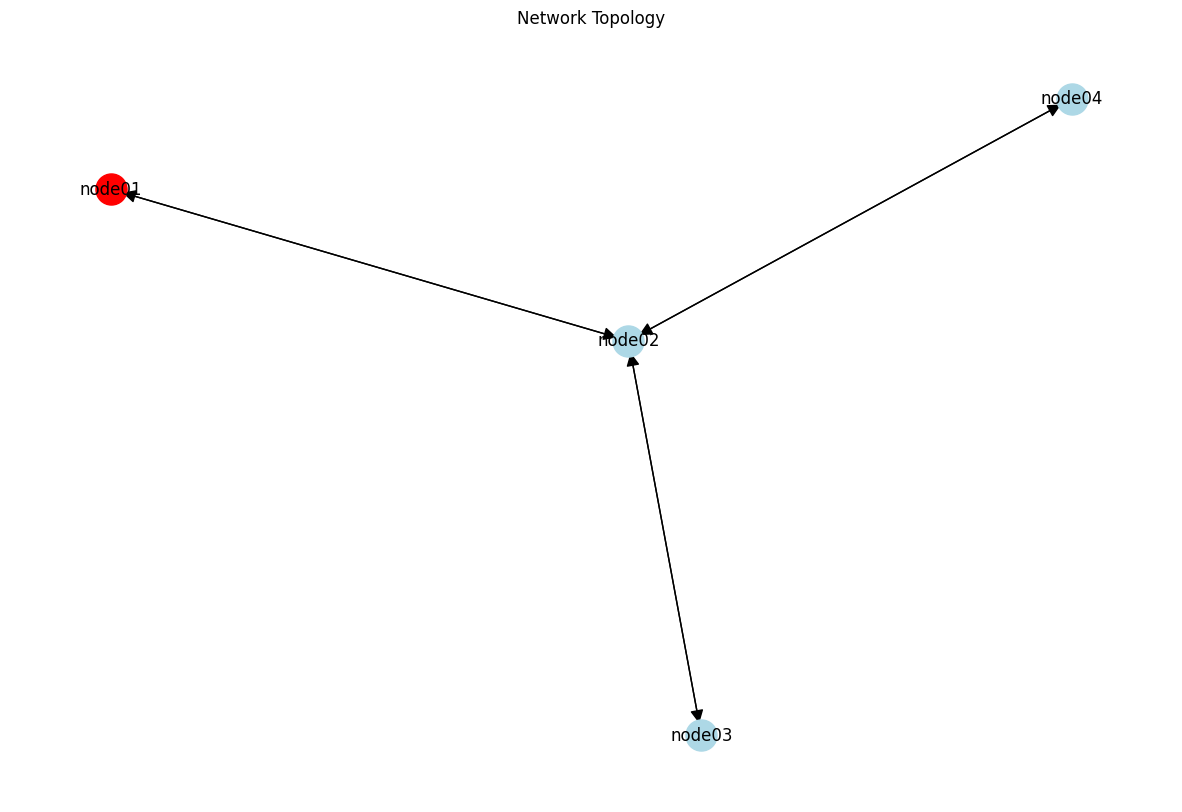

In [12]:
plt.figure(figsize=(15,10))
pos = nx.spring_layout(graph, k=1, iterations=500)

# Draw client nodes in one color and regular nodes in another
client_nodes_to_draw = [node for node in graph.nodes() if node in client_node_names]
general_nodes_to_draw = [node for node in graph.nodes() if node not in client_node_names]

nx.draw_networkx_nodes(graph, pos, nodelist=client_nodes_to_draw, node_color='red', node_size=500)
nx.draw_networkx_nodes(graph, pos, nodelist=general_nodes_to_draw, node_color='lightblue', node_size=500)
nx.draw_networkx_edges(graph, pos, arrows=True, arrowsize=20)
nx.draw_networkx_labels(graph, pos)

plt.title("Network Topology")
plt.axis("off")

plt.show()

## Configure NFD faces and routes

In [37]:
grouped_routes = routing_table.groupby('Source')

def find_dict_by_node_pair(data, target_pair):
    return next((d for d in data if d['Node pair'] == target_pair), None)

total_connections = count()

for source, routes in grouped_routes:
    # Routes is a complete table where all rows have the same source
    targets = routes[routes['Target'].notna()]['Target'].unique()
    
    source_node = experiment_slice.get_node(source)
    for target in targets:
        target_node = experiment_slice.get_node(target)
        
        next_hop = routes[routes['Target'].eq(target)]['Next_Hop'].unique()[0]
        next_hop_node = experiment_slice.get_node(next_hop)
        
        # Set connections for CLIENT nodes
        if source in client_node_names:
            neighbor_node = experiment_slice.get_node(target)
            node_pair = tuple(sorted([source, next_hop]))
            
            isSourceA = node_pair.index(source) == 0
            isNextHopA = node_pair.index(next_hop) == 0
            
            if target == next_hop:
                print(f'\n==================================================\n')
                print(f"> Direct connecting client {source} and {target}\n")
            
                interfaces = find_dict_by_node_pair(interface_table, node_pair)
                
                if None != interfaces:
                    if isSourceA:
                        source_node_interface_name = interfaces['Node A']
                    else:
                        source_node_interface_name = interfaces['Node B']
        
                    source_node_interface = source_node.get_interface(name=source_node_interface_name)
                    local_nic_name = f"dev://{source_node_interface.get_device_name()}"
                    
                    if isNextHopA:
                        next_hop_interface_name = interfaces['Node A']
                    else:
                        next_hop_interface_name = interfaces['Node B']
                        
                    next_hop_interface = next_hop_node.get_interface(name=next_hop_interface_name)
                    remote_mac_address = f"ether://[{next_hop_interface.get_mac()}]"
                    
                    # Create face to be used for the connection
                    source_node.execute(f'nfdc face create remote {remote_mac_address} local {local_nic_name}')
                    source_node.execute(f'nfdc route add / {remote_mac_address}')
            
        else:
            # Set NFD connections for other nodes
            print(f'\n==================================================\n')
            if target == next_hop:
                print(f"> Direct connecting {source} and {target}\n")
            else:
                if target in client_node_names:
                    print(f"> Connecting {source} with client {target}\n")
                else:
                    print(f"> Connecting {source} with {target}\n")
            
            # Set strategy as multicast
            source_node.execute('nfdc strategy set /hydra/group /localhost/nfd/strategy/multicast')
                
            node_pair = tuple(sorted([source, next_hop]))
            
            isSourceA = node_pair.index(source) == 0
            isNextHopA = node_pair.index(next_hop) == 0
            
            interfaces = find_dict_by_node_pair(interface_table, node_pair)
            
            if None != interfaces:
                if isSourceA:
                    source_node_interface_name = interfaces['Node A']
                else:
                    source_node_interface_name = interfaces['Node B']

                source_node_interface = source_node.get_interface(name=source_node_interface_name)
                local_nic_name = f"dev://{source_node_interface.get_device_name()}"
                
                if isNextHopA:
                    next_hop_interface_name = interfaces['Node A']
                else:
                    next_hop_interface_name = interfaces['Node B']
                    
                next_hop_interface = next_hop_node.get_interface(name=next_hop_interface_name)
                remote_mac_address = f"ether://[{next_hop_interface.get_mac()}]"
                
                # Create face to be used for the connections
                source_node.execute(f'nfdc face create remote {remote_mac_address} local {local_nic_name}')
                    
                # Create NFD connections
                try:
                    source_node.execute(f'nfdc route add /hydra/{target} {remote_mac_address}')
                    source_node.execute(f'nfdc route add /{target} {remote_mac_address}')
                    source_node.execute(f'sleep 2')
                except Exception as e:
                    traceback.print_exc(e)
                
                source_node.execute(f'nfdc route add /hydra/group {remote_mac_address}')
                
                total_connections.next()

if total_connections == routing_table_rows:
    print(f'All {routing_table_rows} connections created.')



> Direct connecting client node01 and node02

face-created id=263 local=dev://enp7s0 remote=ether://[1e:72:62:2f:5d:d7] persistency=persistent reliability=off congestion-marking=off congestion-marking-interval=100ms default-congestion-threshold=65536B mtu=1500
route-add-accepted prefix=/ nexthop=263 origin=static cost=0 flags=child-inherit expires=never


> Direct connecting node02 and node01

strategy-set prefix=/hydra/group strategy=/localhost/nfd/strategy/multicast/v=4
face-created id=268 local=dev://enp9s0 remote=ether://[0a:44:9d:cd:9a:85] persistency=persistent reliability=off congestion-marking=off congestion-marking-interval=100ms default-congestion-threshold=65536B mtu=1500
route-add-accepted prefix=/hydra/node01 nexthop=268 origin=static cost=0 flags=child-inherit expires=never
route-add-accepted prefix=/node01 nexthop=268 origin=static cost=0 flags=child-inherit expires=never
route-add-accepted prefix=/hydra/group nexthop=268 origin=static cost=0 flags=child-inherit expire

In [14]:
# from datetime import datetime
# from datetime import timezone
# from datetime import timedelta

# #Set end host to now plus 14 days
# end_date = (datetime.now(timezone.utc) + timedelta(days=14)).strftime("%Y-%m-%d %H:%M:%S %z")
# try:
#     experiment_slice.renew(end_date)
# except Exception as e:
#     print(f"Exception: {e}")